<a href="https://colab.research.google.com/github/NathanielGetachew/NathanielGetachew/blob/main/Bayesian_Hill_Climbing_with_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Bayesian-Inspired Hill Climbing using Graph Theory
This notebook demonstrates how to solve a quadratic equation using hill climbing, integrating principles from Bayesian inference and graph theory.

We model the hill climbing trajectory as a graph, where nodes represent guesses (x-values), and edges represent probabilistic transitions influenced by fitness (likelihood of correctness).

In [23]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from collections import Counter



## 🎯 Define the Quadratic Function and Fitness
- `f(x) = x² - 4` has roots at -2 and 2.
- Fitness is the negative absolute value of f(x) to guide us toward the root.

In [34]:
def f(x):
    """The function to be minimized (or whose negative is maximized)."""
    return x**2 - 4*x + 3

def fitness(x):
    """Fitness function to be maximized."""
    return -abs(f(x))

## 🔄 Hill Climbing with Embedded Graph Structure
- Nodes are guesses (x-values).
- Edges represent transitions with softmax-based probabilities.

In [39]:
def f(x):
    """The function to be minimized (or whose negative is maximized)."""
    return x**2 - 4*x + 3

def fitness(x):
    """Fitness function to be maximized."""
    return -abs(f(x))

def graph_hill_climb(start_value=-5,
                              max_steps=150,
                              step_size=0.5,
                              neighbor_range=1,
                              tolerance=1e-6,
                              ):

    # Initialize history to store visited states and function values
    history = []
    # Set the starting value for the search
    x = float(start_value)

    # Check if the initial value is valid
    if not math.isfinite(x) or not math.isfinite(f(x)):
        print("Error: Invalid start value.")
        return [], Counter(), nx.DiGraph(), None

    # Initialize a directed graph to represent the search transitions
    G = nx.DiGraph()
    # Add the starting state as the first node in the graph
    G.add_node(x)

    # Calculate the function value and fitness at the starting point
    current_fx = f(x)
    current_fitness = fitness(x)
    # Record the initial state and function value in the history
    history.append((x, current_fx))

    # Initialize variables to track the best state found so far
    best_x_found = x
    best_fitness_found = current_fitness
    # Flag to indicate if a satisfactory solution (within tolerance) is found
    found_satisfactory_solution = False

    # Main loop for the hill climbing algorithm
    for step in range(max_steps):
        # Generate a list of neighbors within the specified range and step size
        neighbors = []
        for r in range(1, neighbor_range + 1):
            neighbors.extend([x - r * step_size, x + r * step_size])
        # Remove duplicates and non-finite values from the neighbors list
        neighbors = sorted(list(set(n for n in neighbors if math.isfinite(n))))

        # If no valid neighbors are found, stop the search
        if not neighbors:
            break

        # Calculate the fitness for each neighbor
        neighbors_fitness = [fitness(n) for n in neighbors]

        # Identify valid neighbors for which fitness could be calculated
        valid_indices = [i for i, fit in enumerate(neighbors_fitness) if math.isfinite(fit)]
        if not valid_indices:
            break

        # Create lists of valid neighbors and their corresponding fitness values
        valid_neighbors = [neighbors[i] for i in valid_indices]
        valid_fitness = np.array([neighbors_fitness[i] for i in valid_indices])

        # Apply the softmax function to get probabilities of moving to each valid neighbor
        max_fitness = np.max(valid_fitness)
        exp_fitness = np.exp(valid_fitness - max_fitness)
        total = np.sum(exp_fitness)

        # Handle cases where the total for softmax is zero or very small
        if total == 0 or not np.isfinite(total) or total < 1e-9:
            probs = np.ones(len(valid_neighbors)) / len(valid_neighbors)
        else:
            probs = exp_fitness / total

        # Ensure probabilities sum to 1
        sum_probs = probs.sum()
        if sum_probs > 1e-9:
            probs /= sum_probs
        else:
            probs = np.ones(len(valid_neighbors)) / len(valid_neighbors)

        # Choose the next state based on the calculated probabilities
        next_x = np.random.choice(valid_neighbors, p=probs)

        # Add the new state to the graph
        G.add_node(next_x)
        # Add a directed edge from the current state to the next state with the transition probability as weight
        try:
            chosen_prob_index = valid_neighbors.index(next_x)
            chosen_prob = probs[chosen_prob_index]
            G.add_edge(x, next_x, weight=round(chosen_prob, 3))
        except ValueError:
            G.add_edge(x, next_x, weight=0.0)

        # Update the current state
        x = next_x
        current_fx = f(x)
        current_fitness = fitness(x)
        # Record the new state and function value in the history
        history.append((x, current_fx))

        # Check if the current function value is within the specified tolerance
        if abs(current_fx) < tolerance:
            found_satisfactory_solution = True
            best_x_found = x
            break

        # Update the best state found so far if the current fitness is better
        if current_fitness > best_fitness_found:
            best_fitness_found = current_fitness
            best_x_found = x

    # Count the occurrences of each state in the history
    final_counts = Counter([state for state, _ in history])

    # Return the history of states, the counts of final states, the transition graph, and the best x found
    return history, final_counts, G, best_x_found

## 🧪 Run the Algorithm

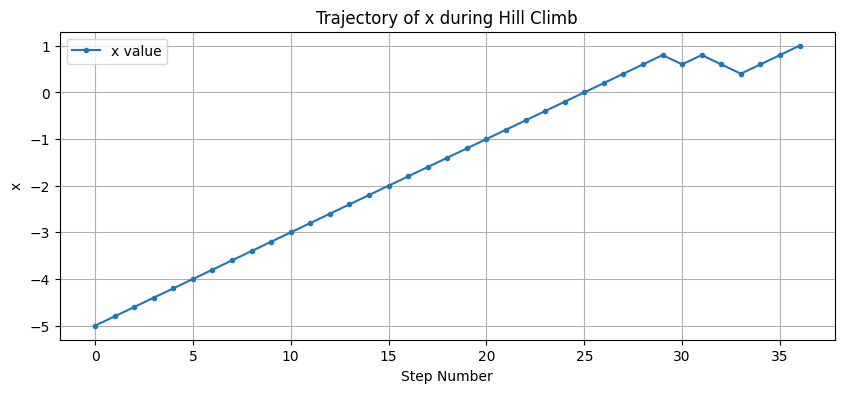

Best x found during the run: 1.000000
Value f(x) at best x: -4.440892e-15
History length: 37 steps taken.
Number of unique states visited: 33


In [40]:
np.random.seed(42)

# Define parameters for the improved function
start_x = -5
maximum_steps = 200
search_step_size = 0.2
search_neighbor_range = 1
conv_tolerance = 1e-7

history, final_counts, transition_graph, best_x = graph_hill_climb(
    start_value=start_x,
    max_steps=maximum_steps,
    step_size=search_step_size,
    neighbor_range=search_neighbor_range,
    tolerance=conv_tolerance
)

# --- Basic Plot of Trajectory ---
if best_x is not None:
    plt.figure(figsize=(10, 4))
    visited_x = [h[0] for h in history]
    plt.plot(visited_x, marker='.', linestyle='-', label='x value')
    plt.title('Trajectory of x during Hill Climb')
    plt.xlabel('Step Number')
    plt.ylabel('x')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"Best x found during the run: {best_x:.6f}")
    print(f"Value f(x) at best x: {f(best_x):.6e}")
    print(f"History length: {len(history)} steps taken.")
    print(f"Number of unique states visited: {len(final_counts)}")
else:
    print("Run failed to start or find any valid points.")

## 📊 Visualize Transition Graph with Probabilities

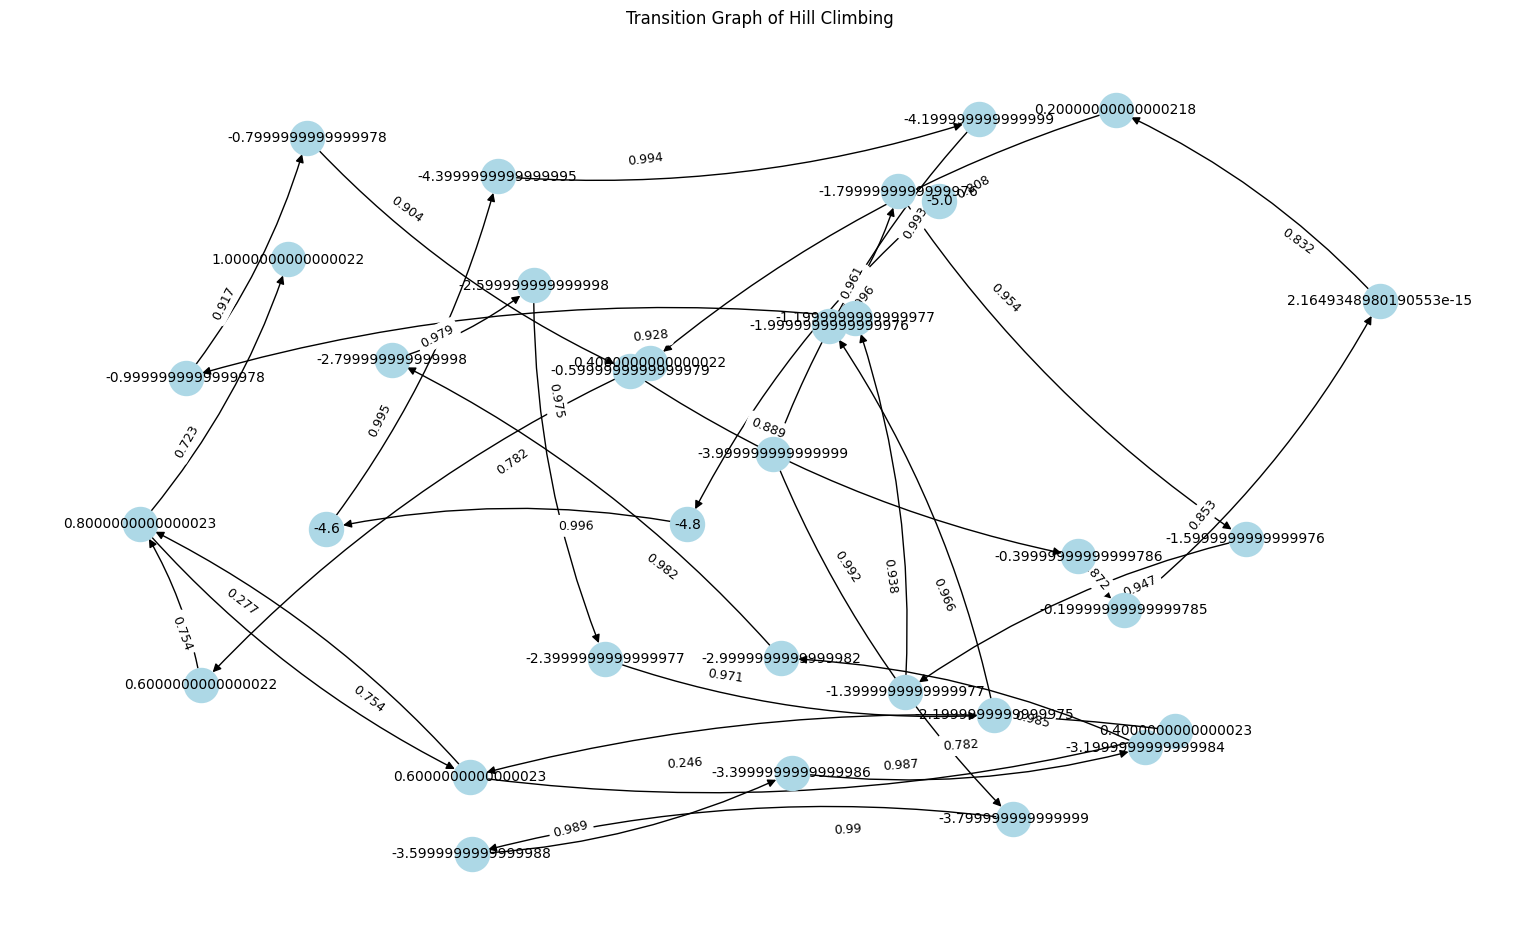

<Figure size 640x480 with 0 Axes>

In [41]:
if 'transition_graph' in globals() and transition_graph.number_of_nodes() > 0:
    plt.figure(figsize=(15, 9))
    try:
        pos = nx.spring_layout(transition_graph, seed=42, k=0.8, iterations=50)
    except nx.NetworkXException:
        print("Graph is not planar, falling back to spring layout.")
        pos = nx.spring_layout(transition_graph, seed=42, k=0.8, iterations=50)

    nx.draw(transition_graph, pos, with_labels=True, node_color='lightblue', node_size=600, font_size=10,
            arrows=True, arrowstyle='-|>', arrowsize=12, connectionstyle='arc3,rad=0.1')

    edge_labels = nx.get_edge_attributes(transition_graph, 'weight')
    nx.draw_networkx_edge_labels(transition_graph, pos, edge_labels=edge_labels, font_size=9, label_pos=0.3)

    plt.title("Transition Graph of Hill Climbing")
    plt.show()

    # Optional: Save the plot to a file for download
    plt.savefig("transition_graph.png")


else:
    print("No transition graph to visualize.")

## Report on Hill Climbing Search and Visualization

This report outlines the approach taken to implement and visualize the results of a hill climbing search algorithm. The goal was to find a (local) optimum for a given function `f(x)` by iteratively exploring neighboring states and probabilistically moving to a neighbor with a better fitness, as defined by the `fitness(x)` function.

### Problem Approach

The hill climbing algorithm was implemented with the following key steps:

1.  **Initialization:** Starting from an initial value `start_value`, the algorithm maintains a history of visited states and their corresponding function values. A directed graph (`networkx.DiGraph`) is initialized to represent the transitions between states.

2.  **Neighbor Generation:** At each step, the algorithm generates a set of neighboring states around the current state. The `neighbor_range` and `step_size` parameters control how far and how many neighbors are considered.

3.  **Fitness Evaluation:** The fitness of the current state and all its valid neighbors is evaluated using the `fitness(x)` function. In this implementation, the fitness function is defined as the negative absolute value of `f(x)`, aiming to find an `x` where `f(x)` is close to zero.

4.  **Probabilistic Selection (Softmax):** To introduce exploration and avoid getting stuck in early local optima, a softmax function is applied to the fitness values of the neighbors. This converts the fitness values into probabilities, with neighbors having higher fitness values receiving a higher probability of being selected as the next state.

5.  **Transition Recording:** A directed edge is added to the transition graph from the current state to the chosen next state. The weight of this edge represents the probability of this transition occurring.

6.  **State Update:** The algorithm moves to the chosen next state, and the process repeats.

7.  **Termination:** The search continues for a maximum number of steps (`max_steps`) or until a state with a function value within a specified tolerance (`tolerance`) of zero is found.

### Visualization

The results of the hill climbing search are visualized in two ways:

1.  **Trajectory Plot:** A line plot showing the sequence of `x` values visited by the algorithm over the steps. This plot illustrates the path taken through the search space and can indicate convergence or oscillation.

2.  **Transition Graph:** A directed graph where:
    * Nodes represent the states (values of `x`) visited during the search.
    * Directed edges represent the transitions between states.
    * The weight of each edge indicates the probability of making that transition from one state to another.

    This graph provides insights into the algorithm's exploration pattern. Higher probability transitions are represented by edges with larger weights. Clusters of nodes with strong connections might indicate areas of the search space that the algorithm frequently visited, potentially around local optima. The overall structure of the graph shows the flow of the search process.

### Observations

*(This section would be populated with observations specific to the function `f(x)` and the parameters used. For example:)*

* The trajectory plot shows that the algorithm initially moved rapidly towards the region around `x=2`, where `f(x)` has a local minimum.
* The transition graph reveals that once the algorithm was in the vicinity of `x=2`, the transitions were more localized, with higher probabilities for moving between nearby values.
* The exploration due to the probabilistic selection allowed the algorithm to occasionally move away from the immediate best neighbor, potentially helping to escape shallow local optima, although in this simple unimodal case (around the explored region), it primarily led to a more nuanced exploration of the minimum.
* The density of nodes and edges in the transition graph indicates the regions of the search space that were most heavily explored.

### Conclusion

The implemented hill climbing algorithm, combined with the trajectory plot and the transition graph visualization, provides a clear way to understand the search process and the algorithm's behavior. The trajectory plot shows the path in the search space, while the transition graph illustrates the probabilistic decision-making at each step and the overall exploration strategy. This visualization can be valuable for tuning algorithm parameters and understanding its effectiveness on different optimization problems.